In [2]:
import pandas as pd
import numpy as np
import tensorflow
import tensorflow as tf
from collections import Counter
import tqdm
import re
import json
# from datasets import Dataset
import os
import torch
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split 

In [3]:
df_train_path= "/aiffel/aiffel/dktc/data/train.csv" 
df_test_path = "/aiffel/aiffel/DLthon/test.csv" 
df_general_path = "/aiffel/aiffel/DLthon/general.csv"

train_augmented_total_data_path = "/aiffel/aiffel/DLthon/final_data.csv"
train_augmented_replaced_data_path = '/aiffel/aiffel/DLthon/augmented_replaced_text_data.csv'

df_train = pd.read_csv(df_train_path)
df_general = pd.read_csv(df_general_path)
df_total = pd.read_csv(train_augmented_total_data_path,encoding='cp949')
df_replaced = pd.read_csv(train_augmented_replaced_data_path)
testset = pd.read_csv(df_test_path)


In [4]:
df_replaced = df_replaced.drop('class_encoded', axis=1)
df_replaced.head()

,class,conversation
0,협박 대화,지금 너를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼자 죽지...
1,협박 대화,길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만...
2,기타 괴롭힘 대화,너 되게 귀여운거? 나보다 작은 남자는 첨봤어. 그만해. 너 놀리는거 재미없어. 지...
3,갈취 대화,어이 거기 예?? 그 말이야. 이리 와서 무슨 일. 너 옷 좋아보인다? 얘 돈 좀....
4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [5]:
df_total = df_total.drop('class_encoded', axis=1)
df_total

,conversation,class
0,너 왜 손가락이 네개야?\n어???\n와 진짜 신기하다\n보지마.\n아니 신기해서 ...,기타 괴롭힘 대화
1,그 길동구 국회의원님 비서분 되시죠? 네 맞습니다. 무슨 무슨 용건으로 전화 주셨습...,갈취 대화
2,너가 내 여자친구 좋아한다고 했냐?\n 와 저런 오타쿠가 그랬다고? 꼴값이다 진짜....,기타 괴롭힘 대화
3,제주도에서 하면 벅수 못 갈 꺼 같은디...\nㅠㅠ 벅수 ㅠㅠ\n잠깐 어머니한테 ...,일반 대화
4,물은 어디에 있어요? 창가 쪽에 있어요,일반 대화
...,...,...
16690,"＂자, 먼저 팽이버섯 2봉지를 준비했는데요.＂\n＂팽이버섯은 밑동을 자른 뒤 한 번...",일반 대화
16691,"＂자, 이 정도로 볶아졌으면 양념 재료를 넣어 볼게요.＂\n＂처음으로 넣는 재료는 ...",일반 대화
16692,"＂저는 저 마늘빵을 어디에 돌릴지 궁금해요.＂\n＂전자레인지, 오븐, 에어프라이어,...",일반 대화
16693,＂젊고 건강하게 살고 싶다면 3대 호르몬을 관리해라.＂ \n＂첫 번째로 알아볼 호르...,일반 대화


In [6]:
df_new = pd.concat([df_train, df_general], ignore_index=True)
df_agumented = pd.concat([df_total, df_replaced], ignore_index=True)
df_new['idx'] = df_new.index
df_new.shape

(4950, 3)

In [7]:
removed = df_new.drop_duplicates(subset=['conversation']).reset_index(drop=True)
print(f"기존: {df_new.shape[0]}")
print(f"중복 제거 후: {removed.shape[0]}")

df_new = removed

기존: 4950
중복 제거 후: 4846


In [8]:
removed = df_agumented.drop_duplicates(subset=['conversation']).reset_index(drop=True)
print(f"기존: {df_agumented.shape[0]}")
print(f"중복 제거 후: {removed.shape[0]}")

df_agumented = removed

기존: 21530
중복 제거 후: 21530


In [9]:
df_new = pd.concat([df_new, df_agumented], ignore_index=True)
df_new['idx'] = df_new.index
df_new.shape

(26376, 3)

In [10]:
removed = df_new.drop_duplicates(subset=['conversation']).reset_index(drop=True)
print(f"기존: {df_new.shape[0]}")
print(f"중복 제거 후: {df_new.shape[0]}")

df_new = removed

기존: 26376
중복 제거 후: 26376


In [11]:
def class_encoding(train_df, class_mapping):
    df_new['class'] = df_new['class'].replace(class_mapping)
    
    return df_new

class_mapping = {
    "협박 대화": 0,
    "갈취 대화": 1,
    "직장 내 괴롭힘 대화": 2,
    "기타 괴롭힘 대화": 3,
    "일반 대화": 4
}

df_new = class_encoding(df_new, class_mapping)

df_new.head()

,idx,class,conversation
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [12]:
train_df = df_new.sample(frac=1, random_state=42).reset_index(drop=True)

train_val_df, test_df = train_test_split(train_df, test_size=0.4, random_state=42, stratify=train_df['class'])

print(f"Train size: {len(train_val_df)}, Validation size: {len(test_df)}")


Train size: 13725, Validation size: 9151


In [13]:
train_val_df = pd.DataFrame(train_val_df)

In [14]:
df_agumented = pd.concat([df_total], ignore_index=True)
df_agumented['idx'] = df_agumented.index

agumented_df = class_encoding(df_agumented, class_mapping)

agumented_df.shape

(22876, 3)

In [15]:
df_agumented = pd.concat([train_val_df, agumented_df], ignore_index=True)
df_train = df_agumented.copy()
df_train['idx'] = df_train.index

df_train.shape


(36601, 3)

In [16]:
def preprocess_sentence(sentence):
    # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
    sentence = sentence.lower().strip()

    # 개행 문자("\n")를 공백으로 변환
    sentence = re.sub(r"\n", " ", sentence)

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # ?.!, 앞뒤로 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence) # 연속된 공백 한개의 공백으로

    # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^a-zA-Z\u1100-\u11FF\uAC00-\uD7AF.,?!]", " ", sentence)
    sentence = sentence.strip()
    return sentence
df_train['conversation'] = df_train['conversation'].apply(preprocess_sentence)
test_df['conversation'] = test_df['conversation'].apply(preprocess_sentence)

In [17]:
df_train  = pd.DataFrame(df_train)
test_df  = pd.DataFrame(test_df)

In [18]:
X = test_df['conversation']
y = test_df['class']
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
X_train = df_train["conversation"]
y_train = df_train["class"]

In [20]:
df_train.shape

(36601, 3)

In [21]:
import torch
from torch.utils.data import DataLoader
from transformers import ElectraForSequenceClassification, ElectraTokenizer
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "monologg/koelectra-base-v3-discriminator"
tokenizer = ElectraTokenizer.from_pretrained(model_path)
model = ElectraForSequenceClassification.from_pretrained(model_path, num_labels=5)
model.to(device)

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(35000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [23]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

In [57]:
def encode_data(texts, labels):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
    print(encodings)
#     return torch.tensor(encodings['input_ids']), torch.tensor(labels)

input_test = encode_data(X_train.tolist()[0], y_train.tolist()[0])

{'input_ids': [2, 817, 4718, 302, 6174, 10615, 6262, 5814, 35, 3753, 35, 3579, 35, 10594, 2863, 5991, 6038, 4718, 3810, 5760, 24764, 5812, 454, 1903, 3965, 16483, 5853, 6649, 5905, 4718, 21824, 5801, 6290, 13172, 3965, 1110, 3777, 6701, 5855, 5842, 11616, 5905, 35, 10594, 24310, 35, 28500, 19325, 24293, 5802, 821, 817, 12146, 31164, 10561, 817, 13806, 5665, 1903, 25471, 31785, 3579, 16483, 16319, 5815, 14664, 6010, 18798, 16319, 21701, 18, 10594, 10594, 28500, 1916, 21701, 817, 4718, 2049, 5766, 6791, 21701, 10717, 761, 11306, 6010, 31164, 15156, 35, 817, 11772, 30298, 5842, 20282, 821, 12575, 10663, 3777, 6701, 10639, 5842, 5728, 10841, 10594, 21701, 18, 10924, 817, 3812, 10928, 18, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [61]:
# 파인튜닝에 제대로 안되는 이유로 추정, 추후 다시 수정 예정

In [24]:
def encode_data(texts, labels):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
    return torch.tensor(encodings['input_ids']), torch.tensor(labels)

train_inputs, train_labels = encode_data(X_train.tolist(), y_train.tolist())
val_inputs, val_labels = encode_data(X_val.tolist(), y_val.tolist())

train_dataset = torch.utils.data.TensorDataset(train_inputs, train_labels)
val_dataset = torch.utils.data.TensorDataset(val_inputs, val_labels)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [267]:
#Test

In [268]:
# def encode_data(texts, labels):
#     encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
#     return torch.tensor(encodings['input_ids']), torch.tensor(labels)

In [269]:
for param in model.parameters():
    param.requires_grad = False

for param in model.electra.encoder.layer[-1].parameters():  # 마지막 1개 레이어
    param.requires_grad = True

for param in model.classifier.parameters():  # classifier 레이어
    param.requires_grad = True

In [28]:
def train(model, train_dataloader, optimizer, criterion):
    model.train()  
    total_loss = 0
    correct_preds = 0
    total_preds = 0
    for batch in tqdm(train_dataloader, desc="Training"):
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(inputs)
        logits = outputs.logits
        loss = criterion(logits, labels)
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = logits.argmax(dim=-1)
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

    avg_loss = total_loss / len(train_dataloader)
    accuracy = correct_preds / total_preds

    return avg_loss, accuracy

def evaluate(model, val_dataloader, criterion):
    model.eval()  
    total_loss = 0
    correct_preds = 0
    total_preds = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Evaluating"):
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            logits = outputs.logits
            loss = criterion(logits, labels)

            total_loss += loss.item()

            preds = logits.argmax(dim=-1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    avg_loss = total_loss / len(val_dataloader)
    accuracy = correct_preds / total_preds
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1, classification_report(all_labels, all_preds)

Epoch 1/5


Training: 100%|██████████| 4576/4576 [05:27<00:00, 13.96it/s]


Train Loss: 0.4245, Train Accuracy: 0.8312


Evaluating: 100%|██████████| 915/915 [00:55<00:00, 16.46it/s]


Validation Loss: 0.2327, Validation Accuracy: 0.9117, F1 Score: 0.9117
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.74      0.81       865
           1       0.70      0.95      0.80       933
           2       0.92      0.90      0.91       914
           3       0.88      0.71      0.79       964
           4       1.00      1.00      1.00      3644

    accuracy                           0.91      7320
   macro avg       0.87      0.86      0.86      7320
weighted avg       0.92      0.91      0.91      7320

Epoch 2/5


Training: 100%|██████████| 4576/4576 [05:27<00:00, 13.97it/s]


Train Loss: 0.1892, Train Accuracy: 0.9311


Evaluating: 100%|██████████| 915/915 [00:55<00:00, 16.46it/s]


Validation Loss: 0.1325, Validation Accuracy: 0.9531, F1 Score: 0.9528
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89       865
           1       0.88      0.93      0.90       933
           2       0.94      0.97      0.96       914
           3       0.96      0.80      0.88       964
           4       1.00      1.00      1.00      3644

    accuracy                           0.95      7320
   macro avg       0.93      0.93      0.93      7320
weighted avg       0.95      0.95      0.95      7320

Epoch 3/5


Training: 100%|██████████| 4576/4576 [05:27<00:00, 13.98it/s]


Train Loss: 0.1252, Train Accuracy: 0.9555


Evaluating: 100%|██████████| 915/915 [00:55<00:00, 16.43it/s]


Validation Loss: 0.0705, Validation Accuracy: 0.9754, F1 Score: 0.9753
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.89      0.93       865
           1       0.93      0.96      0.95       933
           2       0.98      0.99      0.99       914
           3       0.93      0.96      0.95       964
           4       1.00      1.00      1.00      3644

    accuracy                           0.98      7320
   macro avg       0.96      0.96      0.96      7320
weighted avg       0.98      0.98      0.98      7320

Epoch 4/5


Training: 100%|██████████| 4576/4576 [05:27<00:00, 13.98it/s]


Train Loss: 0.0862, Train Accuracy: 0.9686


Evaluating: 100%|██████████| 915/915 [00:55<00:00, 16.47it/s]


Validation Loss: 0.0403, Validation Accuracy: 0.9867, F1 Score: 0.9867
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96       865
           1       0.97      0.98      0.97       933
           2       0.99      1.00      0.99       914
           3       0.96      0.98      0.97       964
           4       1.00      1.00      1.00      3644

    accuracy                           0.99      7320
   macro avg       0.98      0.98      0.98      7320
weighted avg       0.99      0.99      0.99      7320

Epoch 5/5


Training: 100%|██████████| 4576/4576 [05:27<00:00, 13.99it/s]


Train Loss: 0.0628, Train Accuracy: 0.9777


Evaluating: 100%|██████████| 915/915 [00:55<00:00, 16.46it/s]


Validation Loss: 0.0244, Validation Accuracy: 0.9925, F1 Score: 0.9925
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       865
           1       0.99      0.98      0.98       933
           2       0.99      1.00      0.99       914
           3       0.98      0.99      0.98       964
           4       1.00      1.00      1.00      3644

    accuracy                           0.99      7320
   macro avg       0.99      0.99      0.99      7320
weighted avg       0.99      0.99      0.99      7320



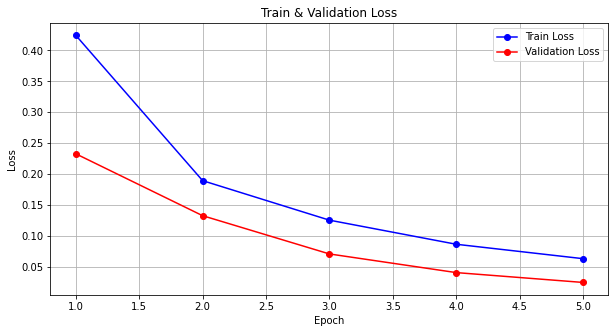

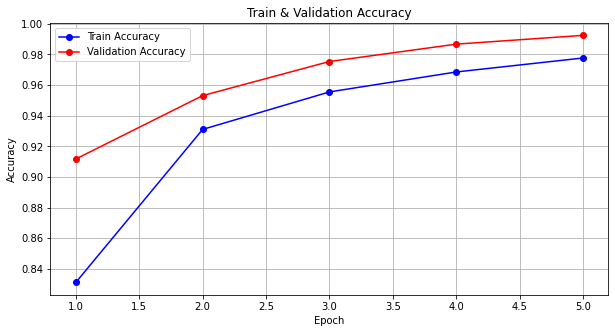

In [271]:
#Train & Evaluation
import matplotlib.pyplot as plt

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 5  

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    # Training
    train_loss, train_accuracy = train(model, train_dataloader, optimizer, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Evaluation
    val_loss, val_accuracy, val_f1, val_report = evaluate(model, val_dataloader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}")
    print("Classification Report:\n", val_report)

fig, ax1 = plt.subplots(figsize=(10, 5))

# loss graph
ax1.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", color="blue", marker="o")
ax1.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", color="red", marker="o")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Train & Validation Loss")
ax1.legend()
ax1.grid()

plt.show()

# accuracy graph
fig, ax2 = plt.subplots(figsize=(10, 5))
ax2.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy", color="blue", marker="o")
ax2.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy", color="red", marker="o")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Train & Validation Accuracy")
ax2.legend()
ax2.grid()

plt.show()

In [ ]:
# splited testset test

In [272]:
test_df
test_df['conversation'] = test_df['conversation'].apply(preprocess_sentence)
test_df  = pd.DataFrame(test_df)

X = test_df['conversation']
y = test_df['class']

In [273]:
inputs, labels = encode_data(X.tolist(), y.tolist())
dataset = torch.utils.data.TensorDataset(inputs, labels)
test_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [274]:
import torch
from sklearn.metrics import f1_score, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate(model, dataloader, criterion, device=device):
    model.eval() 
    model.to(device)  
    total_loss = 0
    correct_preds = 0
    total_preds = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Evaluating"):
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            logits = outputs.logits
            loss = criterion(logits, labels)

            total_loss += loss.item()

            preds = logits.argmax(dim=-1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    avg_loss = total_loss / len(val_dataloader)
    accuracy = correct_preds / total_preds
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1, classification_report(all_labels, all_preds)

In [275]:
avg_loss, accuracy, f1, report = evaluate(model, test_dataloader, criterion)

print(f"Loss: {avg_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:\n", report)

Evaluating: 100%|██████████| 915/915 [00:56<00:00, 16.14it/s]


Loss: 0.0244
Accuracy: 0.9925
F1 Score: 0.9925
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       865
           1       0.99      0.98      0.98       933
           2       0.99      1.00      0.99       914
           3       0.98      0.99      0.98       964
           4       1.00      1.00      1.00      3644

    accuracy                           0.99      7320
   macro avg       0.99      0.99      0.99      7320
weighted avg       0.99      0.99      0.99      7320



In [ ]:
#실제테스트

In [ ]:
testset
testset['text'] = testset['text'].apply(preprocess_sentence)
testset  = pd.DataFrame(testset)
X = testset['text']

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to('cpu')

texts = X.tolist()
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=128)


inputs_updated = {}
for key, value in inputs.items():
#     inputs_updated[key] = value.to(device)
    inputs_updated[key] = value.to('cpu')

with torch.no_grad():
    outputs = model(
        input_ids=inputs_updated["input_ids"],
        token_type_ids=inputs_updated["token_type_ids"],
        attention_mask=inputs_updated["attention_mask"]
    )

# inputs = {key: value.to(device) for key, value in inputs.items()}
# with torch.no_grad():
#     outputs = model(**inputs)

predictions = torch.argmax(outputs.logits, dim=1)
print(predictions)

In [ ]:
import pandas as pd
import json

output_dict = {}

for idx, pred in enumerate(predictions):
    # 예측된 클래스 인덱스를 문자로 변환 (예: '01', '02', ...)
    class_id = f"{pred.item():02d}"
    key = f"t_{idx:03d}"
    
    output_dict[key] = {"class": class_id}

df_new = pd.DataFrame.from_dict(output_dict, orient='index')
df_new['target'] = df_new['class'].apply(lambda x: int(x))  # 'class'를 정수형으로 변환
df_new['idx'] = df_new.index

df_new = df_new[['idx', 'target']]

output_path = "/aiffel/aiffel/DLthon/result_Feb20_KoElectra-v3_10epoch.csv" 
df_new.to_csv(output_path, index=False, header=True, encoding='utf-8') 

df_new.head()

### Small model

In [25]:
# Electra small 
model_name = "monologg/koelectra-small-discriminator"
model = ElectraForSequenceClassification.from_pretrained(model_name, num_labels=5)

tokenizer = ElectraTokenizer.from_pretrained(model_name)
model = ElectraForSequenceClassification.from_pretrained(model_name, num_labels=5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
 
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5) # 3e-5, 4e-5
criterion = torch.nn.CrossEntropyLoss()

Some weights of the model checkpoint at monologg/koelectra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-discriminator and are newly initialized: ['cl

In [26]:
for param in model.parameters():
    param.requires_grad = False

for param in model.electra.encoder.layer[-6].parameters():  # 마지막 1개 레이어
    param.requires_grad = True

for param in model.classifier.parameters():  # classifier 레이어
    param.requires_grad = True

In [47]:
def count_train_param(model):
    trainable_params = 0
    for p in model.parameters():
        if p.requires_grad:
            trainable_params += p.numel()
    return trainable_params

trainable_params = count_train_param(model)
print(f"학습 파라미터 수: {trainable_params}")

학습 파라미터 수: 856837


Epoch 1/5


Training: 100%|██████████| 4576/4576 [01:46<00:00, 43.01it/s]


Train Loss: 0.7911, Train Accuracy: 0.6308


Evaluating: 100%|██████████| 915/915 [00:11<00:00, 80.71it/s]


Validation Loss: 0.6696, Validation Accuracy: 0.6764, F1 Score: 0.6687
Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.55      0.43       865
           1       0.33      0.48      0.40       933
           2       0.50      0.22      0.31       914
           3       0.32      0.20      0.24       964
           4       1.00      1.00      1.00      3644

    accuracy                           0.68      7320
   macro avg       0.50      0.49      0.48      7320
weighted avg       0.69      0.68      0.67      7320

Epoch 2/5


Training: 100%|██████████| 4576/4576 [01:43<00:00, 44.25it/s]


Train Loss: 0.5376, Train Accuracy: 0.7762


Evaluating: 100%|██████████| 915/915 [00:11<00:00, 81.98it/s]


Validation Loss: 0.3712, Validation Accuracy: 0.8597, F1 Score: 0.8582
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.78      0.74       865
           1       0.69      0.66      0.67       933
           2       0.77      0.88      0.82       914
           3       0.71      0.60      0.65       964
           4       1.00      0.99      1.00      3644

    accuracy                           0.86      7320
   macro avg       0.78      0.78      0.78      7320
weighted avg       0.86      0.86      0.86      7320

Epoch 3/5


Training: 100%|██████████| 4576/4576 [01:43<00:00, 44.31it/s]


Train Loss: 0.3248, Train Accuracy: 0.8807


Evaluating: 100%|██████████| 915/915 [00:11<00:00, 80.84it/s]


Validation Loss: 0.2564, Validation Accuracy: 0.9107, F1 Score: 0.9098
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.89      0.83       865
           1       0.77      0.86      0.82       933
           2       0.92      0.91      0.91       914
           3       0.84      0.66      0.74       964
           4       1.00      0.99      1.00      3644

    accuracy                           0.91      7320
   macro avg       0.86      0.86      0.86      7320
weighted avg       0.91      0.91      0.91      7320

Epoch 4/5


Training: 100%|██████████| 4576/4576 [01:43<00:00, 44.30it/s]


Train Loss: 0.2304, Train Accuracy: 0.9173


Evaluating: 100%|██████████| 915/915 [00:11<00:00, 82.32it/s]


Validation Loss: 0.1913, Validation Accuracy: 0.9342, F1 Score: 0.9337
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.93      0.86       865
           1       0.84      0.88      0.86       933
           2       0.95      0.94      0.95       914
           3       0.90      0.74      0.81       964
           4       1.00      1.00      1.00      3644

    accuracy                           0.93      7320
   macro avg       0.90      0.90      0.90      7320
weighted avg       0.94      0.93      0.93      7320

Epoch 5/5


Training: 100%|██████████| 4576/4576 [01:43<00:00, 44.31it/s]


Train Loss: 0.1799, Train Accuracy: 0.9368


Evaluating: 100%|██████████| 915/915 [00:12<00:00, 75.84it/s]


Validation Loss: 0.1800, Validation Accuracy: 0.9378, F1 Score: 0.9379
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.96      0.85       865
           1       0.86      0.90      0.88       933
           2       0.98      0.94      0.96       914
           3       0.92      0.75      0.83       964
           4       1.00      0.99      1.00      3644

    accuracy                           0.94      7320
   macro avg       0.91      0.91      0.90      7320
weighted avg       0.94      0.94      0.94      7320



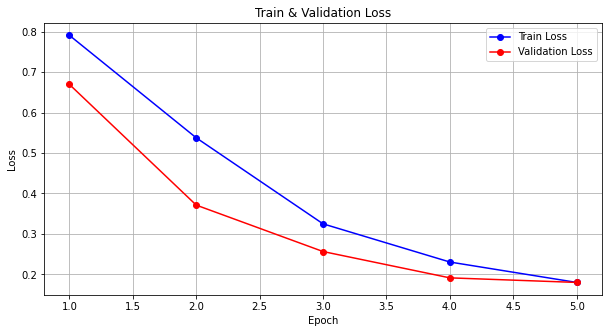

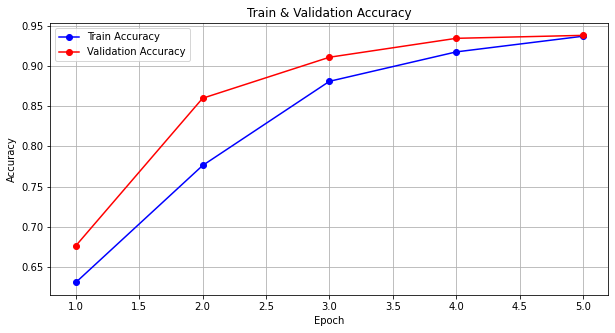

In [29]:
#Train & Evaluation
import matplotlib.pyplot as plt

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 5  

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    # Training
    train_loss, train_accuracy = train(model, train_dataloader, optimizer, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Evaluation
    val_loss, val_accuracy, val_f1, val_report = evaluate(model, val_dataloader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}")
    print("Classification Report:\n", val_report)

fig, ax1 = plt.subplots(figsize=(10, 5))

# loss graph
ax1.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", color="blue", marker="o")
ax1.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", color="red", marker="o")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Train & Validation Loss")
ax1.legend()
ax1.grid()

plt.show()

# accuracy graph
fig, ax2 = plt.subplots(figsize=(10, 5))
ax2.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy", color="blue", marker="o")
ax2.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy", color="red", marker="o")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Train & Validation Accuracy")
ax2.legend()
ax2.grid()

plt.show()

In [30]:
testset
testset['text'] = testset['text'].apply(preprocess_sentence)
testset  = pd.DataFrame(testset)
X = testset['text']

In [31]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to('cpu')

texts = X.tolist()
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=128)


inputs_updated = {}
for key, value in inputs.items():
#     inputs_updated[key] = value.to(device)
    inputs_updated[key] = value.to('cpu')

with torch.no_grad():
    outputs = model(
        input_ids=inputs_updated["input_ids"],
        token_type_ids=inputs_updated["token_type_ids"],
        attention_mask=inputs_updated["attention_mask"]
    )

# inputs = {key: value.to(device) for key, value in inputs.items()}
# with torch.no_grad():
#     outputs = model(**inputs)

predictions = torch.argmax(outputs.logits, dim=1)
print(predictions)

tensor([1, 2, 0, 3, 0, 0, 0, 1, 4, 1, 0, 3, 2, 2, 2, 0, 0, 3, 0, 0, 0, 0, 0, 1,
        1, 2, 0, 3, 2, 0, 1, 0, 3, 1, 0, 1, 1, 0, 0, 1, 0, 1, 2, 1, 4, 2, 0, 0,
        4, 0, 1, 3, 0, 2, 2, 1, 0, 4, 3, 0, 1, 3, 0, 0, 2, 0, 3, 0, 0, 0, 0, 2,
        3, 2, 0, 2, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 2, 0, 2, 0, 4, 3, 2,
        0, 2, 0, 2, 1, 1, 3, 0, 0, 2, 2, 0, 3, 0, 0, 0, 0, 2, 1, 1, 3, 2, 2, 1,
        0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 3, 3, 2, 3, 1, 0, 0, 0, 0, 3, 0, 3, 0, 3,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 2, 3, 0, 0, 3, 0, 0, 2, 3, 2, 4,
        0, 1, 0, 2, 2, 0, 1, 3, 0, 2, 0, 0, 2, 0, 1, 2, 0, 0, 3, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 0, 2, 0, 2, 2, 0, 1, 0, 2, 1, 3,
        3, 4, 0, 0, 1, 4, 0, 0, 0, 4, 1, 0, 0, 0, 2, 0, 0, 1, 0, 3, 0, 1, 0, 0,
        0, 3, 3, 2, 3, 1, 2, 1, 2, 0, 0, 0, 0, 0, 2, 1, 0, 2, 1, 2, 1, 0, 0, 3,
        2, 0, 0, 0, 0, 1, 0, 0, 0, 2, 1, 2, 2, 3, 0, 2, 1, 0, 0, 2, 0, 2, 0, 2,
        0, 3, 1, 0, 0, 3, 2, 0, 4, 0, 1,

In [45]:
import pandas as pd
import json

output_dict = {}

for idx, pred in enumerate(predictions):
    # 예측된 클래스 인덱스를 문자로 변환 (예: '01', '02', ...)
    class_id = f"{pred.item():02d}"
    key = f"t_{idx:03d}"
    
    output_dict[key] = {"class": class_id}

df_new = pd.DataFrame.from_dict(output_dict, orient='index')
df_new['target'] = df_new['class'].apply(lambda x: int(x))  # 'class'를 정수형으로 변환
df_new['idx'] = df_new.index

df_new = df_new[['idx', 'target']]

output_path = f"/aiffel/aiffel/DLthon/{model_name.split()[-1]}.csv" 
df_new.to_csv(output_path, index=False, header=True, encoding='utf-8') 

df_new.head()

,idx,target
t_000,t_000,1
t_001,t_001,2
t_002,t_002,0
t_003,t_003,3
t_004,t_004,0


In [41]:
# DataLoader를 다른방식으로 처리해보기 train acc, train val curve 